<a href="https://colab.research.google.com/github/tasdid25/Deep-Learning/blob/main/Fine_Tune_LLAMA_2_Using_QLoRA_Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetungin LLaMA 2 by QLoRA

This notebook describes the step-by-step, detailed explanation on how to finetune LLaMA 2 on a single GPU efficiently with QLoRA. Following are the topics covered in the video:
1. Overview of Supervised fine-tuning and RLHF
2. Why is Finetuning required?
3. What is LoRA and how is it helpful?
4. How to prepare an Instruct Dataset for finetune generative models?
5. How to train the LLAMA 2 model using Instruct Dataset?
6. Inference using fine-tuned LLAMA 2 Model.


YouTube Linke: https://www.youtube.com/watch?v=psR6kMjDttM

In [ ]:
!pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install transformers==4.31
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets
!pip install evaluate
!pip install -qqq trl==0.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
import torch
import time
import evaluate
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
import random

In [ ]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})


###  Preprocess the Dialog-Summary Dataset

You need to convert the dialog-summary (prompt-response) pairs into explicit instructions for the LLM. Prepend an instruction to the start of the dialog with `Summarize the following conversation` and to the start of the summary with `Summary` as follows:

Training prompt (dialogue):
```
Summarize the following conversation.

    Chris: This is his part of the conversation.
    Antje: This is her part of the conversation.
    
Summary:
```

Training response (summary):
```
Both Chris and Antje participated in the conversation.
```

Then preprocess the prompt-response dataset into tokens and pull out their `input_ids` (1 per token).

In [ ]:
def format_instruction(dialogue: str, summary: str):
	return f"""### Instruction:
Summarize the following conversation.

### Input:
{dialogue.strip()}

### Summary:
{summary}
""".strip()


In [ ]:
def generate_instruction_dataset(data_point):

    return {
        "dialogue": data_point["dialogue"],
        "summary": data_point["summary"],
        "text": format_instruction(data_point["dialogue"],data_point["summary"])
    }

In [ ]:
def process_dataset(data: Dataset):
    return (
        data.shuffle(seed=42)
        .map(generate_instruction_dataset).remove_columns(['id', 'topic',])
    )

In [ ]:
# sample_dataset = dataset.filter(lambda example, index: index % 100 == 0, with_indices=True)

In [ ]:

# sample_dataset["train"] = process_dataset(sample_dataset["train"])
# sample_dataset["test"] = process_dataset(sample_dataset["validation"])
# sample_dataset["validation"] = process_dataset(sample_dataset["validation"])

In [ ]:
## APPLYING PREPROCESSING ON WHOLE DATASET
dataset["train"] = process_dataset(dataset["train"])
dataset["test"] = process_dataset(dataset["validation"])
dataset["validation"] = process_dataset(dataset["validation"])
# Select 1000 rows from the training split
train_data = dataset['train'].shuffle(seed=42).select([i for i in range(500)])

# Select 100 rows from the test and validation splits
test_data = dataset['test'].shuffle(seed=42).select([i for i in range(50)])
validation_data = dataset['validation'].shuffle(seed=42).select([i for i in range(50)])

train_data,test_data,validation_data

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

(Dataset({
     features: ['dialogue', 'summary', 'text'],
     num_rows: 500
 }),
 Dataset({
     features: ['dialogue', 'summary', 'text'],
     num_rows: 50
 }),
 Dataset({
     features: ['dialogue', 'summary', 'text'],
     num_rows: 50
 }))

In [ ]:
dataset["train"]["text"][0]

"### Instruction:\nSummarize the following conversation.\n\n### Input:\n#Person1#: Hello, Anna speaking!\n#Person2#: Hey, Anna, this is Jason.\n#Person1#: Jason, where have you been hiding lately? You know it's been a long time since your last call. Have you been good?\n#Person2#: Yes. How are you, Anna?\n#Person1#: I am fine. What have you been doing?\n#Person2#: Working. I've been really busy these days. I got a promotion.\n#Person1#: That's great, congratulations!\n#Person2#: Thanks. I am feeling pretty good about myself too. You know, bigger office, a raise and even an assistant.\n#Person1#: That's good. So I guess I'll have to make an appointment to see you.\n#Person2#: You are kidding.\n#Person1#: How long have you been working there?\n#Person2#: A bit over two years. This is a fast-moving company, and seniority isn't the only factor in deciding promotions.\n#Person1#: How do you like your new boss?\n#Person2#: She is very nice and open-minded.\n#Person1#: Much better than the la

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id =  "NousResearch/Llama-2-7b-hf"
# model_id = "meta-llama/Llama-2-13b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

## ZERO-SHOT INFERENCE WITH LLAMA-2 7B

In [ ]:
index = 0

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

### Input:
{dialogue}

### Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=100,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1468: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

### Input:
#Person1#: Did you enjoy your weekend at the highland hotel? I heard it's and excellent place to stay and has good facilities.
#Person2#: I had a wonderful time. The rooms are not very big, but they are well furnished. The restaurant is excellent and reasonably priced. There's a sauna and a Jacuzzi.
#Person1#: Do they have a swimming pool?
#Person2#: No, they don't. they have a beauty parlor, but I didn't go there.
#Person1#: What's the service like?
#Person2#: It's very good. Check in and check out at the reception only took a few minutes. The wait staff is very good. A waiter recommended their baked fish, which tasted wonderful. The hotel was quite full, so I'd suggest making a reservation if you intend to go there. The hotel offers a discount at the weekends.
#Person1#: It sounds perfect. Did you have any complaints at a

# Training Setup

### LoRA Explained
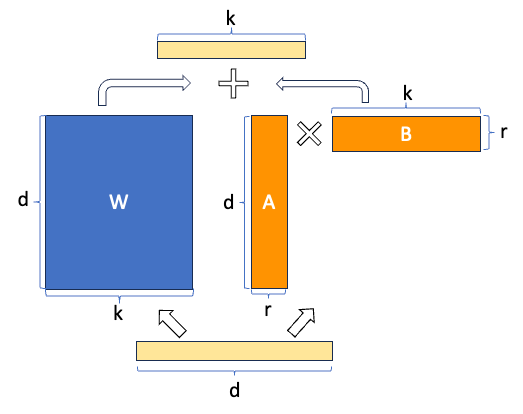

### Merging LoRA ADAPTER With BASE MODEL
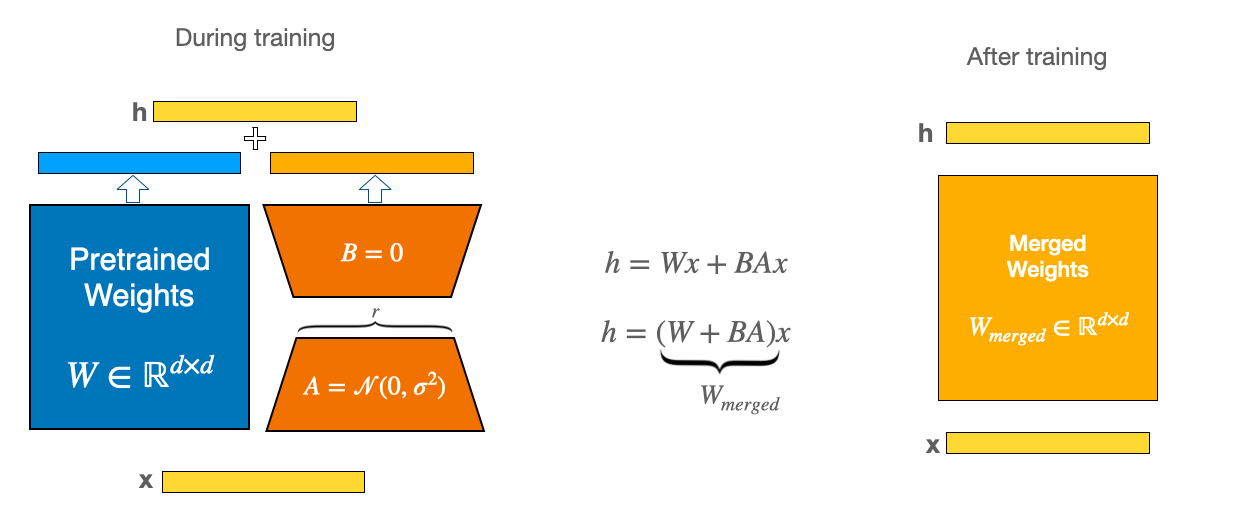

Then we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():

        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=64,
    # target_modules=["query_key_value"],
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], #specific to Llama models.
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
print_trainable_parameters(model)

trainable params: 16777216 || all params: 3517190144 || trainable%: 0.477006226934315


# Training

Run the cell below to run the training! For the sake of the demo, we just ran it for few steps just to showcase how to use this integration with existing tools on the HF ecosystem.

In [ ]:
OUTPUT_DIR = "llama2-docsum-adapter"

%load_ext tensorboard
%tensorboard --logdir llama2-docsum-adapter/runs

<IPython.core.display.Javascript object>

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=1e-4,
    fp16=True,
    max_grad_norm=0.3,
    num_train_epochs=2,
    evaluation_strategy="steps",
    eval_steps=0.2,
    warmup_ratio=0.05,
    save_strategy="epoch",
    group_by_length=True,
    output_dir=OUTPUT_DIR,
    report_to="tensorboard",
    save_safetensors=True,
    lr_scheduler_type="cosine",
    seed=42,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [ ]:
from trl import SFTTrainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=validation_data,
    peft_config=lora_config,
    dataset_text_field="text",
    max_seq_length=1024,
    tokenizer=tokenizer,
    args=training_arguments,
)

trainer.train()

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
13,1.294400,1.324347
26,1.303000,1.265420
39,1.251900,1.254807
52,1.104600,1.253352


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=62, training_loss=1.280252843133865, metrics={'train_runtime': 213.0681, 'train_samples_per_second': 4.693, 'train_steps_per_second': 0.291, 'total_flos': 6161813997944832.0, 'train_loss': 1.280252843133865, 'epoch': 1.98})

In [ ]:
peft_model_path="./peft-dialogue-summary"

trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./peft-dialogue-summary/tokenizer_config.json',
 './peft-dialogue-summary/special_tokens_map.json',
 './peft-dialogue-summary/tokenizer.model',
 './peft-dialogue-summary/added_tokens.json',
 './peft-dialogue-summary/tokenizer.json')

# Inference

In [ ]:
from transformers import TextStreamer
model.config.use_cache = True
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

peft_model_dir = "peft-dialogue-summary"

# load base LLM model and tokenizer
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    peft_model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    load_in_4bit=True,
)
tokenizer = AutoTokenizer.from_pretrained(peft_model_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
index = 0

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

### Input:
{dialogue}

### Summary:
"""

input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()
# output = tokenizer.decode(
#     trained_model.generate(
#         inputs_ids,
#         max_new_tokens=100,
#     )[0],
#     skip_special_tokens=True
# )
outputs = trained_model.generate(input_ids=input_ids, max_new_tokens=100, )
output= tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'TRAINED MODEL GENERATED TEXT :\n{output}')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:391: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn('Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')


---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

### Input:
#Person1#: Did you enjoy your weekend at the highland hotel? I heard it's and excellent place to stay and has good facilities.
#Person2#: I had a wonderful time. The rooms are not very big, but they are well furnished. The restaurant is excellent and reasonably priced. There's a sauna and a Jacuzzi.
#Person1#: Do they have a swimming pool?
#Person2#: No, they don't. they have a beauty parlor, but I didn't go there.
#Person1#: What's the service like?
#Person2#: It's very good. Check in and check out at the reception only took a few minutes. The wait staff is very good. A waiter recommended their baked fish, which tasted wonderful. The hotel was quite full, so I'd suggest making a reservation if you intend to go there. The hotel offers a discount at the weekends.
#Person1#: It sounds perfect. Did you have any complaints at a

# Merge Trained LoRA Adapter With BASE MODEL and Push Model to Hub

---



In [ ]:
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    peft_model_dir,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
)
# Merge LoRA and base model
merged_model = trained_model.merge_and_unload()

# Save the merged model
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")

# push merged model to the hub
# merged_model.push_to_hub("user/repo")
# tokenizer.push_to_hub("user/repo")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

('merged_model/tokenizer_config.json',
 'merged_model/special_tokens_map.json',
 'merged_model/tokenizer.model',
 'merged_model/added_tokens.json',
 'merged_model/tokenizer.json')